# Getting started with TensorFlow

This is taken from [Getting Started with TensorFlow ](https://www.tensorflow.org/get_started/get_started).
It covers the basic use of TensorFlow.

## Importing TensorFlow
- TensorFlow is Python library.
- Python libraries are imported using an `import` statement.
- The things in TensorFlow must then be prefixed with `tensorflow`, e.g. `tensorflow.constant()`.
- To save us some typing we can include an `as` clause to the `import` statement, giving e.g. `tf.constant()`.

In [1]:
# Import tensorflow with the shortened name tf.
import tensorflow as tf

## Data flow graphs

- TensorFlow thinks of computations as graphs.
- Starting nodes of the graph are data sources.
- Intermediate nodes are operations.
- Ending nodes are data outputs.

![Data flow](https://raw.githubusercontent.com/ianmcloughlin/images/master/dataflow.png)
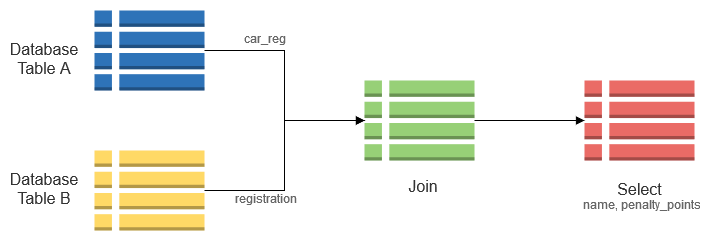

## Creating data nodes

- We create nodes using functions like `tf.constant()`.
- They're just placeholders, until we `run` the graph later.

In [2]:
# Create a node representing the float value 3.0.
node1 = tf.constant(3.0, dtype=tf.float32)

# Create a node representing the valuee 4.0.
node2 = tf.constant(4.0) # also tf.float32 implicitly

# Print the nodes to the screen.
print(node1, node2)

Tensor("Const:0", shape=(), dtype=float32) Tensor("Const_1:0", shape=(), dtype=float32)


## Running the session

- We create a session, which encapsulates an execution of the graph, creating a scope.
- Then we run the graph in the session.
- It's not very interesting, our graph just contains two separate, unconnected nodes.

In [3]:
# Create a new session.
sess = tf.Session()

# Run the two constant nodes in the session.
print(sess.run([node1, node2]))

[3.0, 4.0]


## Perform an operation
- Here we create an `add` node that adds its inputs.
- We tell it to use `node1` and `node2` as input.
- We now have three nodes, two containing constant numbers with data flowing from these to the third node which adds them.

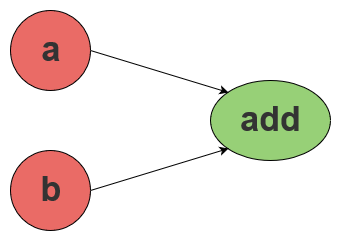

In [4]:
# Create an adder node, connect constant nodes to it.
node3 = tf.add(node1, node2)

# Print the node.
print("node3:", node3)

# Run the node in the session and print output.
print("sess.run(node3):", sess.run(node3))

node3: Tensor("Add:0", shape=(), dtype=float32)
sess.run(node3): 7.0


## Placeholder nodes
- Constants are fine, but what if we want to use variables?
- We use `tf.placeholder()`.

In [5]:
# Create two placeholder nodes representing floats.
a = tf.placeholder(tf.float32)
b = tf.placeholder(tf.float32)

# Create an adder node with connections from a and b, using shorthand. 
adder_node = a + b  # + provides a shortcut for tf.add(a, b)

Now when we run the graph we supply the values of the placeholders.

In [6]:
# Run the adder node in the session with single values supplied for a and b.
print(sess.run(adder_node, {a: 3.0, b: 4.5}))

# Run the adder node in the session with two values supplied for a and b.
print(sess.run(adder_node, {a: [1.0, 3.0], b: [2.0, 4.0]}))

7.5
[3. 7.]


## Implicit nodes
- TensorFlow is clever when it comes to syntax.
- We can create a fourth node that triples the value from `adder_node` implicitly.
- Think of this as operator overloading.

In [7]:
# Create a new node that multiplies the output of adder_node by three.
add_and_triple = adder_node * 3.0

# Run that node in the session.
print(sess.run(add_and_triple, {a: 3, b: 4.5}))

22.5


## Linear models with gradient descent
- Let's have a quick look at doing something more complicated with TensorFlow.
- We'll try to estimate the best line that fits the following data.
- You can probably guess that the best line should have slope 2.0 and intercept -1.0.
- Let's get TensorFlow to use a complicated algorithm to estimate this!

In [1]:
# Import numpy.
import numpy as np

# Set the actual slope and y-intercept. We'll estimate these later.
# Why do we call them W and b?
W_actual = 2.0
b_actual = -1.0

# Create some example x and y values.
x_vals = np.arange(0.0, 10.0, 2.0)
y_vals = W_actual * x_vals + b_actual

print(x_vals)
print(y_vals)

[0. 2. 4. 6. 8.]
[-1.  3.  7. 11. 15.]


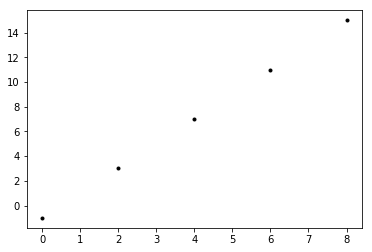

In [9]:
# Tell Jupyter to display plots in the notebook.
%matplotlib inline

# Import matplotlib.
import matplotlib.pyplot as plt

# Plot the x and y values we've created.
plt.plot(x_vals, y_vals, 'k.')
plt.show()

## Initialise some nodes
- We'll create two values with guess values to start.
- The first is `W`, and this will be the slope of the line.
- The second is `b` and this will be the value of `y` when `x` is zero (the intercept).
- Note that sometimes we'd call these m and c, but in tensorflow we usually use w for weight and b for bias.
- We'll create a placeholder for our x values, called `x`.
- Then we'll create a "function" which multiplies the placeholder `x` by `W` (which is 0.3 to start) and then adds `b` (which is -0.3 to start).
- In reality we'd set these values randomly.

In [10]:
# Create a node for W an give it an initialvalue of 0.3.
W = tf.Variable([.3], dtype=tf.float32)

# Create a node for b an give it an initialvalue of -0.3.
b = tf.Variable([-.3], dtype=tf.float32)

# Create a placeholder for x values.
x = tf.placeholder(tf.float32)

# Create a node repesenting the line.
linear_model = W * x + b

## The goal
- Our goal will be to adjust `W` and `b` so that when we perform this "function" on our x values we get outputs that are close to our y values.
- Then `W` and `b` are good fits for our data.
- Let's get the session running.

In [11]:
# Initialise the tensorflow global variables like W and b in the session.
init = tf.global_variables_initializer()
sess.run(init)

# Print the current values of W * x + b where x is x_vals.
print(sess.run(linear_model, {x: x_vals}))

# Print out actual y values.
print(y_vals)

[-0.3         0.3         0.90000004  1.5         2.1000001 ]
[-1.  3.  7. 11. 15.]


## Bad predictions
- Currently our predictions are not very good.
- We want the above values (`(W * x) + b`) to be close to our actual y values.
- To improve them, we must somehow quantify how bad our predictions are.
- The typical way to do this is to subtract our predictions from what we know the values should be, square each of those values and add them together. We call this *the sum of the squares*.
- Note a key idea here: we must *know* in advance what some of the `y` values should be. This is the *supervised* part of supervised learning. It's like we're teaching the model by giving it feedback on a test we give it.
- Let's tell TensorFlow how to quantify how bad the model is.

In [12]:
# Create a variable node for y values.
y = tf.placeholder(tf.float32)

# Create a cost function node.
squared_deltas = tf.square(linear_model - y)

# Tell tensorflow to reduce the cost function (by summing the output values).
loss = tf.reduce_sum(squared_deltas)

# Run the loss function node to calculate the current cost.
print(sess.run(loss, {x: x_vals, y: y_vals}))

301.65


## Perfect fit
- Let's compare that loss to what we know is the perfect fit model, when `W` is `W_actual` and `b` is `b_actual`.
- We can use the `tf.assign` function to temporarily assign these values.
- The loss is 0 then, as expected.
- Any other values for `W` and `b` will move the loss away from 0.
- Question: can the loss be less than 0?

In [13]:
# Assign W and b
fixW = tf.assign(W, [W_actual])
fixb = tf.assign(b, [b_actual])
sess.run([fixW, fixb])
print(sess.run(loss, {x: x_vals, y: y_vals}))

0.0


## Optimisation
- Optimisation can be tricky, and there is a lot of theory to go through.
- Luckily TensorFlow comes with built-in optimisation methods.
- You must understand how optimisations work to do them right.
- For now, let's just give them a whirl in the knowledge that they're more complex.
- One of the most popular optimisation methods is gradient descent, based on calculus.
- It works by making small changes in the parameters (`W` and `b`) in the right direction.

In [14]:
optimizer = tf.train.GradientDescentOptimizer(0.001)
train = optimizer.minimize(loss)

## Running the optimisation
- We run the optimiser 1000 times.
- With each iteration the values are getting closer and closer to some optimum.

In [15]:
sess.run(init) # reset values to incorrect defaults.
for i in range(1000):
  sess.run(train, {x: x_vals, y: y_vals})

print(sess.run([W, b, loss], {x: x_vals, y: y_vals}))

[array([1.9936954], dtype=float32), array([-0.9626834], dtype=float32), 0.0023217637]


#### Visualise
Let's have a look at our fitted line (in red) compared the actual line (in blue).

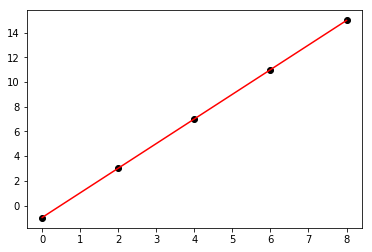

In [16]:
# Get the W and b estimated values from Tensorflow.
W_est = W.eval(sess)
b_est = b.eval(sess)

# Plot the actual values as black circles.
plt.plot(x_vals, y_vals, 'ko')
# Plot the estimated line from Tensorflow.
plt.plot(x_vals, W_est * x_vals + b_est, 'r-')

plt.show()

#### End